![](https://www.nuplan.org/static/media/nuPlan_final.3fde7586.png)

### Contents

1. [Introduction](#introduction)
2. [Accessing sensor data through NuPlanScenario](#nuplan_scenario)

# Introduction <a name="introduction"></a>


Welcome to the nuPlan sensor data tutorial. This tutorial is a short guide on how to access sensor data. The sensor data are stored as object blobs (.jpg for images and .pcd for pointcloud) which are separate from the log database (.db) files. The database files simply provide a reference to the corresponding sensor blob. **Hence, you need to have both the database files and the sensor blobs downloaded and stored in the correct directories**. It is recommended that you set up your file structure as illustrated below.

Note that the name of the DB corresponds to the directory name where the sensor blob is stored. For example, the sensor blobs for `nuplan-v1.1/splits/mini/2021.05.12.22.00.38_veh-35_01008_01518.db` lives in `nuplan-v1.1/sensor_blobs/2021.05.12.22.00.38_veh-35_01008_01518/`.


```
~/nuplan
├── exp
│   └── ${USER}
│       ├── cache
│       │   └── <cached_tokens>
│       └── exp
│           └── my_nuplan_experiment
└── dataset
    ├── maps
    │   ├── nuplan-maps-v1.0.json
    │   ├── sg-one-north
    │   │   └── 9.17.1964
    │   │       └── map.gpkg
    │   ├── us-ma-boston
    │   │   └── 9.12.1817
    │   │       └── map.gpkg
    │   ├── us-nv-las-vegas-strip
    │   │   └── 9.15.1915
    │   │       └── map.gpkg
    │   └── us-pa-pittsburgh-hazelwood
    │       └── 9.17.1937
    │           └── map.gpkg
    └── nuplan-v1.1
        ├── splits
        │     ├── mini
        │     │    ├── 2021.05.12.22.00.38_veh-35_01008_01518.db
        │     │    ├── 2021.06.09.17.23.18_veh-38_00773_01140.db
        │     │    ├── ...
        │     │    └── 2021.10.11.08.31.07_veh-50_01750_01948.db
        │     └── trainval
        │          ├── 2021.05.12.22.00.38_veh-35_01008_01518.db
        │          ├── 2021.06.09.17.23.18_veh-38_00773_01140.db
        │          ├── ...
        │          └── 2021.10.11.08.31.07_veh-50_01750_01948.db
        └── sensor_blobs
              ├── 2021.05.12.22.00.38_veh-35_01008_01518
              │    ├── CAM_F0
              │    │     ├── c082c104b7ac5a71.jpg
              │    │     ├── af380db4b4ca5d63.jpg
              │    │     ├── ...
              │    │     └── 2270fccfb44858b3.jpg
              │    ├── CAM_B0
              │    ├── CAM_L0
              │    ├── CAM_L1
              │    ├── CAM_L2
              │    ├── CAM_R0
              │    ├── CAM_R1
              │    ├── CAM_R2
              │    └──MergedPointCloud
              │         ├── 03fafcf2c0865668.pcd
              │         ├── 5aee37ce29665f1b.pcd
              │         ├── ...
              │         └── 5fe65ef6a97f5caf.pcd
              │
              ├── 2021.06.09.17.23.18_veh-38_00773_01140
              ├── ...
              └── 2021.10.11.08.31.07_veh-50_01750_01948

```

## Setup

To be able to access all resources within this notebook, make sure Jupyter is launched at the root of this repo. The path of the notebook should be `/notebook/<repo_root>`.

### IMPORTANT
Please make sure that you have the following downloaded:
- nuplan_mini dataset from `nuplan-v1.1_mini.zip`
- sensor blobs from `nuplan-v1.1_mini_camera_0.zip` and `nuplan-v1.1_mini_lidar_0.zip`

Make sure that the files are extracted following the file structure shown above.

In [5]:
# Useful imports
import os
from pathlib import Path
import tempfile
import hydra
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

from tutorials.utils.tutorial_utils import setup_notebook

setup_notebook()

# Accessing sensor data through NuPlanScenario<a name="nuplan_scenario"></a>

[NuplanScenario](https://github.com/motional/nuplan-devkit/blob/master/nuplan/planning/scenario_builder/nuplan_db/nuplan_scenario.py#L45) is the primary method of accessing the sensor data. NuPlanScenario provides convenience methods such as [`get_sensors_at_iteration()`](https://github.com/motional/nuplan-devkit/blob/master/nuplan/planning/scenario_builder/nuplan_db/nuplan_scenario.py#L293) and [`get_past_sensors()`](https://github.com/motional/nuplan-devkit/blob/master/nuplan/planning/scenario_builder/nuplan_db/nuplan_scenario.py#L372). These methods return a single [Sensors](https://github.com/motional/nuplan-devkit/blob/master/nuplan/planning/simulation/observation/observation_type.py#L51) dataclass instance or a list of `Sensors` instances, respectively. The dataclass instance contains both lidar pointclouds and images. It is in the form of a dictionary that maps sensor channels to sensor data.
```
@dataclass
class Sensors(Observation):
    """
    Output of sensors, e.g. images and pointclouds.
    """

    pointcloud: Optional[Dict[LidarChannel, LidarPointCloud]]
    images: Optional[Dict[CameraChannel, Image]]
```

Let's see how it works below. First we need to create an instance of NuPlanScenario. Usually, this is taken care of by a builder during training or simulation. However, for the sake of demonstration we will manually create one.

In [6]:
from nuplan.common.actor_state.vehicle_parameters import get_pacifica_parameters
from nuplan.planning.scenario_builder.nuplan_db.nuplan_scenario import NuPlanScenario, CameraChannel, LidarChannel
from nuplan.planning.scenario_builder.nuplan_db.nuplan_scenario_utils import ScenarioExtractionInfo

NUPLAN_DATA_ROOT = "/home/PJLAB/weitiantian/data/Nuplan"
NUPLAN_MAP_VERSION = "nuplan-maps-v1.0"
NUPLAN_MAPS_ROOT = "/home/PJLAB/weitiantian/data/Nuplan/maps"
NUPLAN_SENSOR_ROOT = f"{NUPLAN_DATA_ROOT}/nuplan-v1.1/sensor_blobs"
TEST_DB_FILE = f"{NUPLAN_DATA_ROOT}/nuplan-v1.1/splits/mini/2021.05.12.22.00.38_veh-35_01008_01518.db"
MAP_NAME = "us-nv-las-vegas"
TEST_INITIAL_LIDAR_PC = "58ccd3df9eab54a3"
TEST_INITIAL_TIMESTAMP = 1620858198150622

scenario = NuPlanScenario(
            data_root=f"{NUPLAN_DATA_ROOT}/nuplan-v1.1/splits/mini",
            log_file_load_path=TEST_DB_FILE,
            initial_lidar_token=TEST_INITIAL_LIDAR_PC,
            initial_lidar_timestamp=TEST_INITIAL_TIMESTAMP,
            scenario_type="scenario_type",
            map_root=NUPLAN_MAPS_ROOT,
            map_version=NUPLAN_MAP_VERSION,
            map_name=MAP_NAME,
            scenario_extraction_info=ScenarioExtractionInfo(
                scenario_name="scenario_name", scenario_duration=20, extraction_offset=1, subsample_ratio=0.5
            ),
            ego_vehicle_parameters=get_pacifica_parameters(),
            sensor_root=NUPLAN_DATA_ROOT+"/nuplan-v1.1/sensor_blobs"
)

In [7]:
from nuplan.database.nuplan_db_orm.nuplandb import NuPlanDB

nuplanDB = NuPlanDB(data_root=NUPLAN_DATA_ROOT, load_path=TEST_DB_FILE, verbose=True)

#
print(nuplanDB.category)

Category(7 entries):
--------------------------------------------------
token                       : fd69059b62a3469f
name                        : vehicle
description                 : Includes all four or more wheeled vehicles, as well as trailers.

token                       : fc95c87b806f48f8
name                        : bicycle
description                 : Includes bicycles, motorcycles and tricycles.

token                       : 6cad906eb0b94bb5
name                        : pedestrian
description                 : All types of pedestrians, incl. strollers and wheelchairs.

(...) 
token                       : 2e810cd3718d49ab
name                        : generic_object
description                 : Animals, debris, pushable/pullable objects, permanent poles.




In [8]:
# from nuplan.database.nuplan_db.db_cli_queries import _get_table_columns_from_db,_get_table_row_count_from_db,get_db_log_duration
# _get_table_columns_from_db(TEST_DB_FILE,"camera")
# _get_table_row_count_from_db(TEST_DB_FILE,"camera")
# get_db_log_duration(TEST_DB_FILE)

# from nuplan.database.nuplan_db.nuplan_scenario_queries import get_sensor_token_by_index_from_db
# from nuplan.database.nuplan_db.nuplan_db_utils import (
#     SensorDataSource,
#     get_camera_channel_sensor_data,
#     get_lidarpc_sensor_data,
# )

# sds = SensorDataSource(table="lidar_box", sensor_table="lidar_pc", sensor_token_column="lidar_pc_token", channel="MergedPointCloud")
# get_sensor_token_by_index_from_db(TEST_DB_FILE, sds, 0)

Now that we have a NuplanScenario instance we can start using the interfaces available. In this tutorial we will use `get_sensors_at_iteration()`. First we want to extract a lidar point cloud and an image from the front facing camera. Take note of the channels `CameraChannel.CAM_F0` and `LidarChannel.MERGED_PC` passed to the method.

In [9]:
sensors = scenario.get_sensors_at_iteration(0, [CameraChannel.CAM_F0, CameraChannel.CAM_B0]) #, LidarChannel.MERGED_PC])
print(sensors)

Sensors(pointcloud=None, images={<CameraChannel.CAM_F0: 'CAM_F0'>: <nuplan.database.utils.image.Image object at 0x7f1e9f5803d0>, <CameraChannel.CAM_B0: 'CAM_B0'>: <nuplan.database.utils.image.Image object at 0x7f1e9f38a5e0>})


As you can see from the print statement, `sensors` stores two dictionaries. One for pointclouds, and one for images. Each dictionary uses the enums `LidarChannel` and `CameraChannel` to map the sensor data to the correct channels. In nuPlan the available channels are: 

```
class CameraChannel(Enum):
    """
    An enum class representing supported camera channels
    """

    CAM_F0 = "CAM_F0"
    CAM_B0 = "CAM_B0"
    CAM_L0 = "CAM_L0"
    CAM_L1 = "CAM_L1"
    CAM_L2 = "CAM_L2"
    CAM_R0 = "CAM_R0"
    CAM_R1 = "CAM_R1"
    CAM_R2 = "CAM_R2"


class LidarChannel(Enum):
    """
    An enum class representing supported lidar channels
    """

    MERGED_PC = "MergedPointCloud"
```

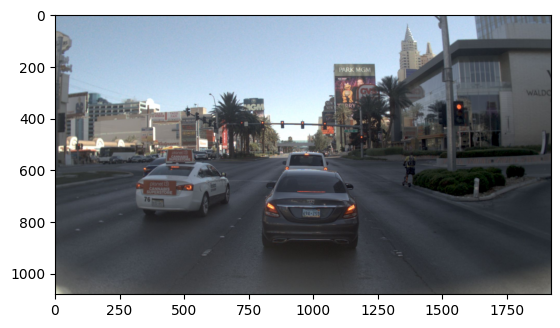

AttributeError: 'Image' object has no attribute 'lidar_pc'

In [12]:
# Lets visualize the image.
img = sensors.images[CameraChannel.CAM_F0]
plt.imshow(img.as_numpy)
plt.show()
img.lidar_pc()

In [11]:
# And then the visualize pointcloud.
pc = sensors.pointcloud[LidarChannel.MERGED_PC]
plt.imshow(pc.render_image())
plt.show()

TypeError: 'NoneType' object is not subscriptable

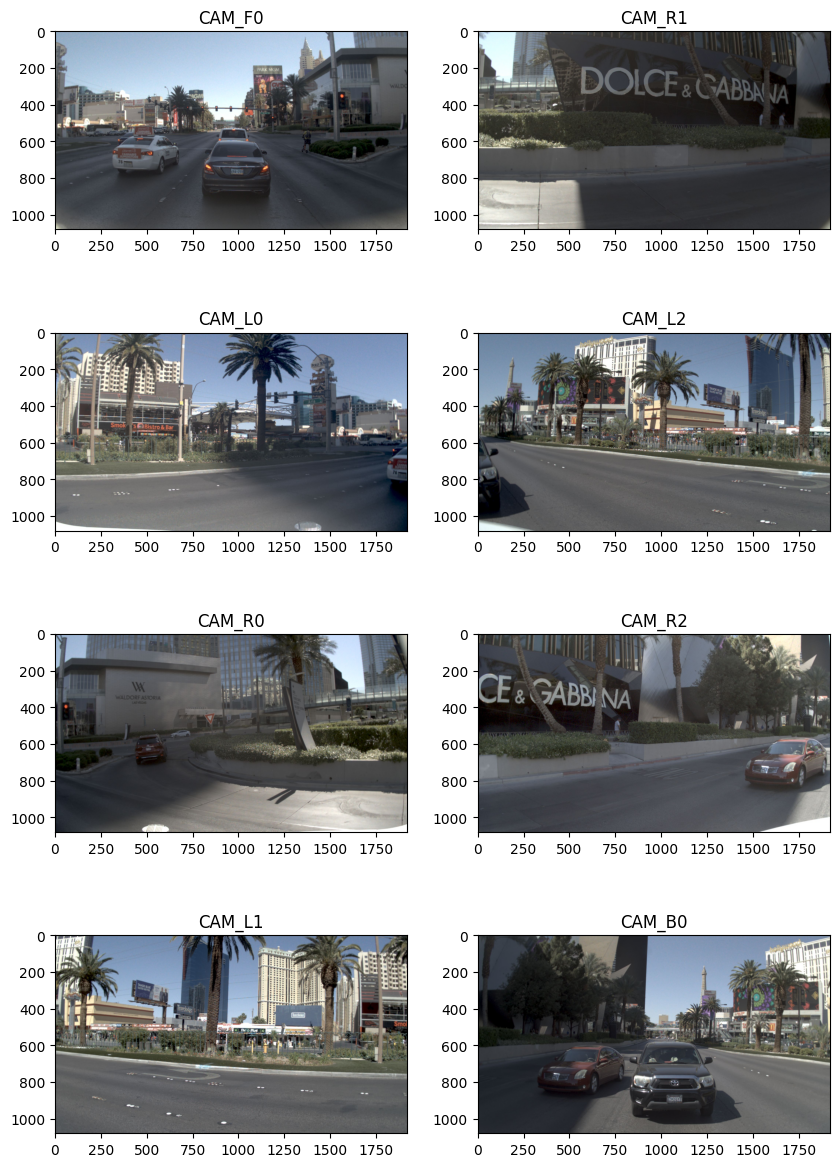

In [ ]:
# All camera channels
sensors = scenario.get_sensors_at_iteration(0, [channel for channel in CameraChannel])


# Visualizing all 8 channels
fig, axarr = plt.subplots(4, 2, figsize=(10, 15))
channel_idx = 0
for channel, img in sensors.images.items():
    row, col = channel_idx % 4, channel_idx // 4
    axarr[row][col].imshow(img.as_numpy)
    axarr[row][col].title.set_text(channel.name)
    channel_idx += 1